In [15]:
# === Core Libraries ===
import os
import sys
import warnings
import numpy as np
import pandas as pd

# === Audio Processing ===
import librosa
import librosa.display
import noisereduce as nr
from scipy.signal import butter, filtfilt, hilbert

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio, display  # Keep for interactive audio playback

# === Machine Learning (Scikit-learn) ===
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# === Traditional ML Models ===
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# === Miscellaneous ===
from tqdm import tqdm  # For progress bars (optional but useful)

# === Warnings ===
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
Crema = "C:/Users/Srinjoy/Documents/CODE/PY/Crema"

# List all files in the dataset directory
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

# Loop through files and extract emotion from filename
for file in crema_directory_list:
    if file.endswith('.wav'):
        file_path.append(os.path.join(Crema, file))
        part = file.split('_')
        
        # Extract emotion code (3rd part of filename)
        if part[2] == 'SAD':
            file_emotion.append('sad')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')

# Create dataframe
Crema_df = pd.DataFrame({'Emotions': file_emotion, 'Path': file_path})

# Drop any unknown entries (if any)
Crema_df = Crema_df[Crema_df.Emotions != 'Unknown'].reset_index(drop=True)

# Display info
print(f" CREMA-D dataset loaded successfully with {len(Crema_df)} samples.")
Crema_df.head()

 CREMA-D dataset loaded successfully with 7442 samples.


,Emotions,Path
0,angry,C:/Users/Srinjoy/Documents/CODE/PY/Crema\1001_...
1,disgust,C:/Users/Srinjoy/Documents/CODE/PY/Crema\1001_...
2,fear,C:/Users/Srinjoy/Documents/CODE/PY/Crema\1001_...
3,happy,C:/Users/Srinjoy/Documents/CODE/PY/Crema\1001_...
4,neutral,C:/Users/Srinjoy/Documents/CODE/PY/Crema\1001_...


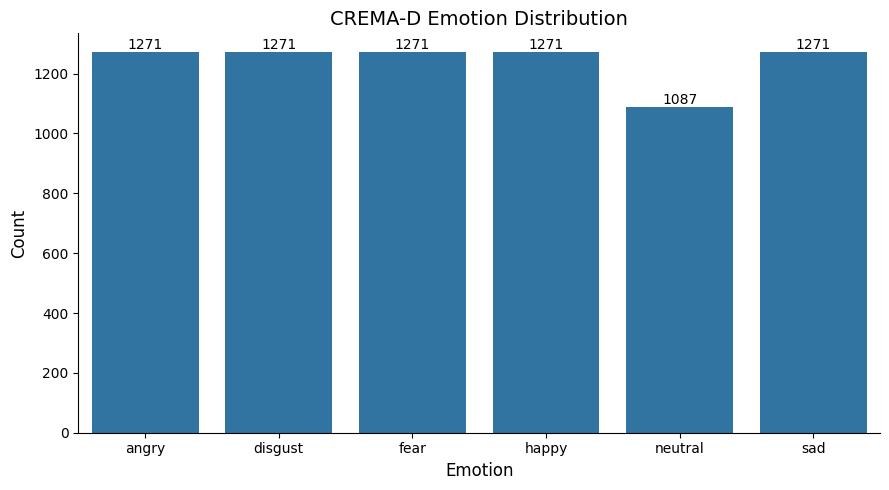


Emotion distribution (count and %):

          count  percent
Emotions                
angry      1271    17.08
disgust    1271    17.08
fear       1271    17.08
happy      1271    17.08
neutral    1087    14.61
sad        1271    17.08


In [3]:
plt.figure(figsize=(9,5))
ax = sns.countplot(x='Emotions', data=Crema_df, order=sorted(Crema_df.Emotions.unique()))
plt.title('CREMA-D Emotion Distribution', fontsize=14)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Count', fontsize=12)
sns.despine(top=True, right=True)
plt.tight_layout()

# annotate counts on bars
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

# save figure (optional)
plt.savefig('crema_emotion_distribution.png', dpi=200)
plt.show()

# Print counts and relative percentages
counts = Crema_df.Emotions.value_counts().sort_index()
percent = (counts / counts.sum() * 100).round(2)
summary_df = pd.DataFrame({'count': counts, 'percent': percent})
print("\nEmotion distribution (count and %):\n")
print(summary_df)



Playing sample for emotion: ANGRY


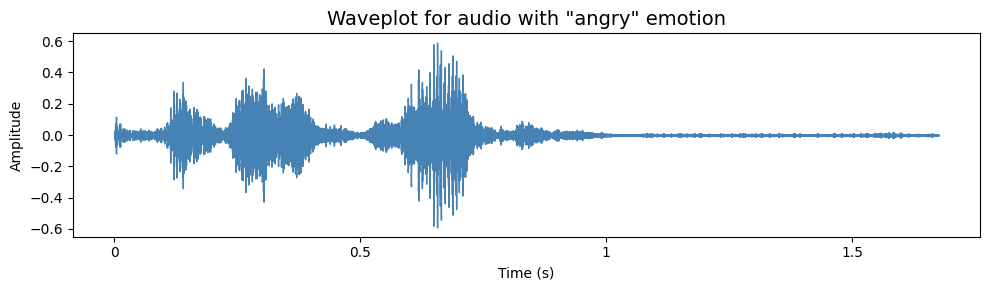

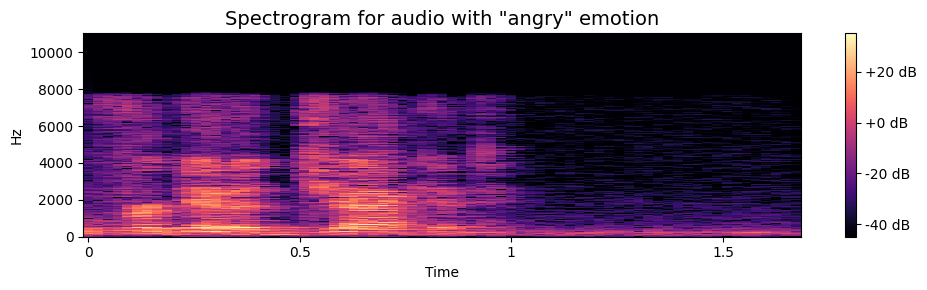


Playing sample for emotion: HAPPY


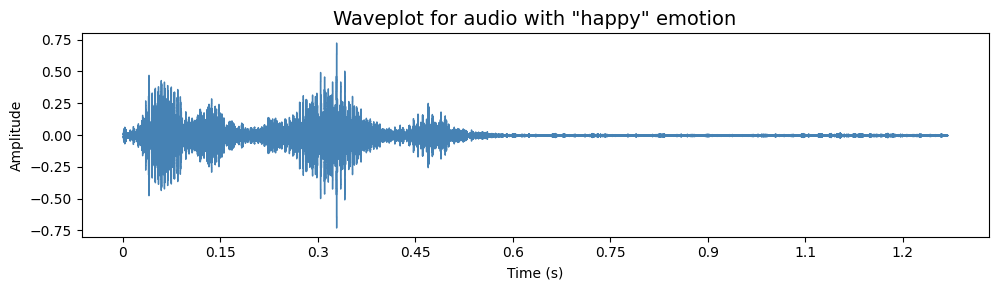

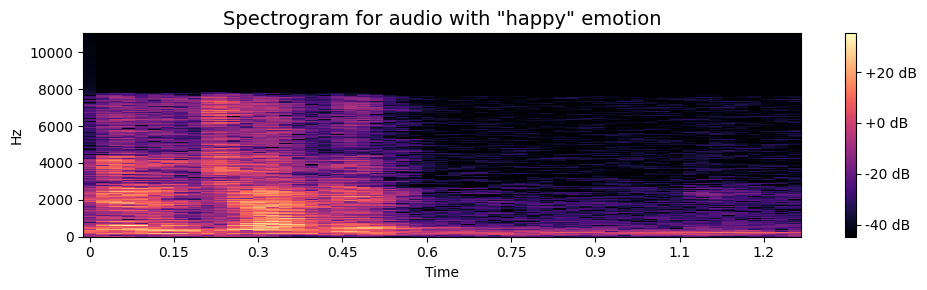


Playing sample for emotion: SAD


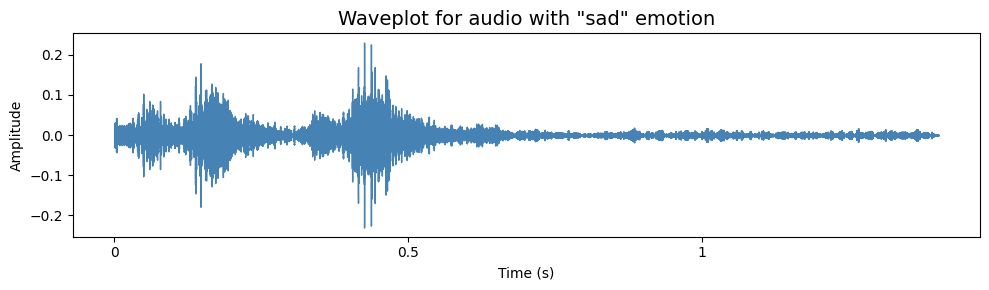

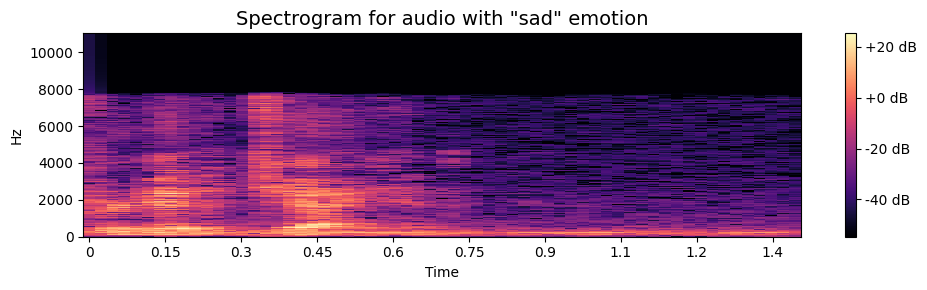


Playing sample for emotion: FEAR


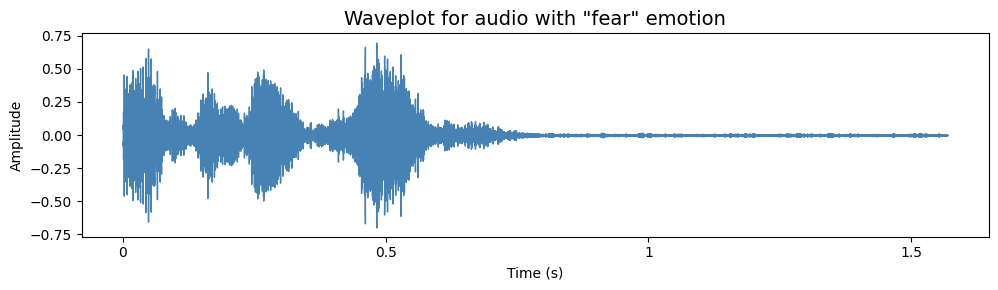

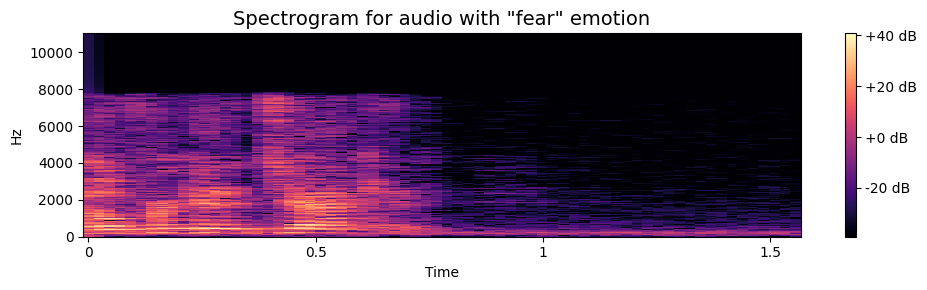


Playing sample for emotion: NEUTRAL


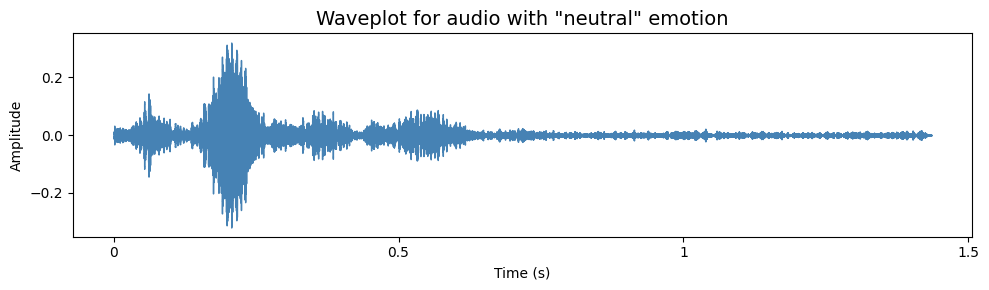

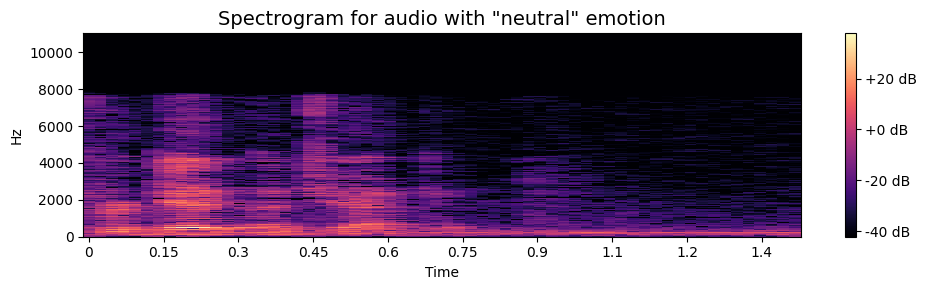


Playing sample for emotion: DISGUST


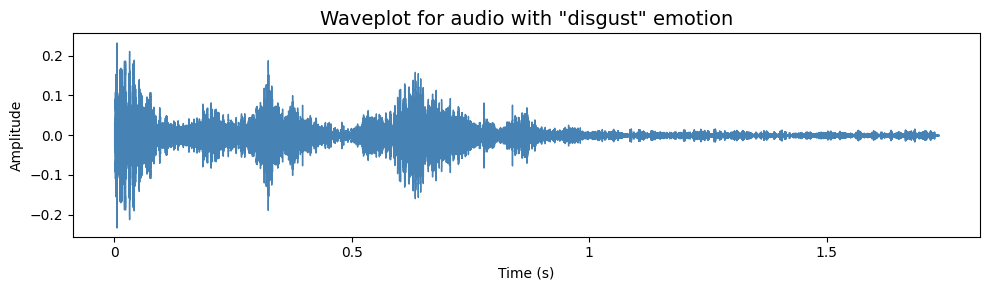

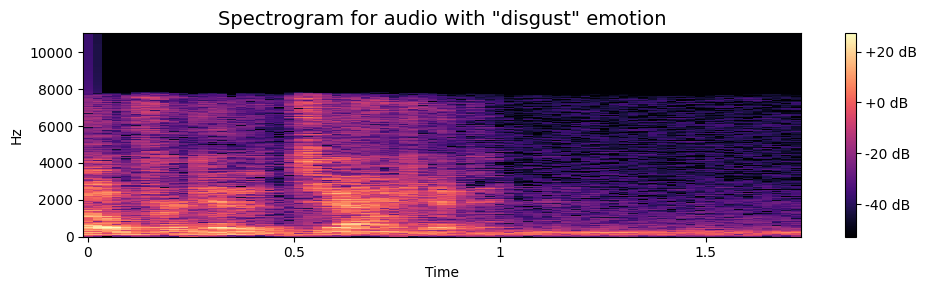

In [4]:
def create_waveshow(data, sr, emotion):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with "{emotion}" emotion', size=14)
    librosa.display.waveshow(data, sr=sr, color='steelblue')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

# Function to plot spectrogram
def create_spectrogram(data, sr, emotion):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(10, 3))
    plt.title(f'Spectrogram for audio with "{emotion}" emotion', size=14)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

# Visualize examples of multiple emotions
sample_emotions = ['angry', 'happy', 'sad', 'fear', 'neutral', 'disgust']
for emotion in sample_emotions:
    try:
        path = np.array(Crema_df.Path[Crema_df.Emotions == emotion])[0]
        data, sr = librosa.load(path, duration=2.5, offset=0.6)
        print(f"\nPlaying sample for emotion: {emotion.upper()}")
        create_waveshow(data, sr, emotion)
        create_spectrogram(data, sr, emotion)
        display(Audio(data, rate=sr))
    except Exception as e:
        print(f"Could not load example for emotion '{emotion}': {e}")

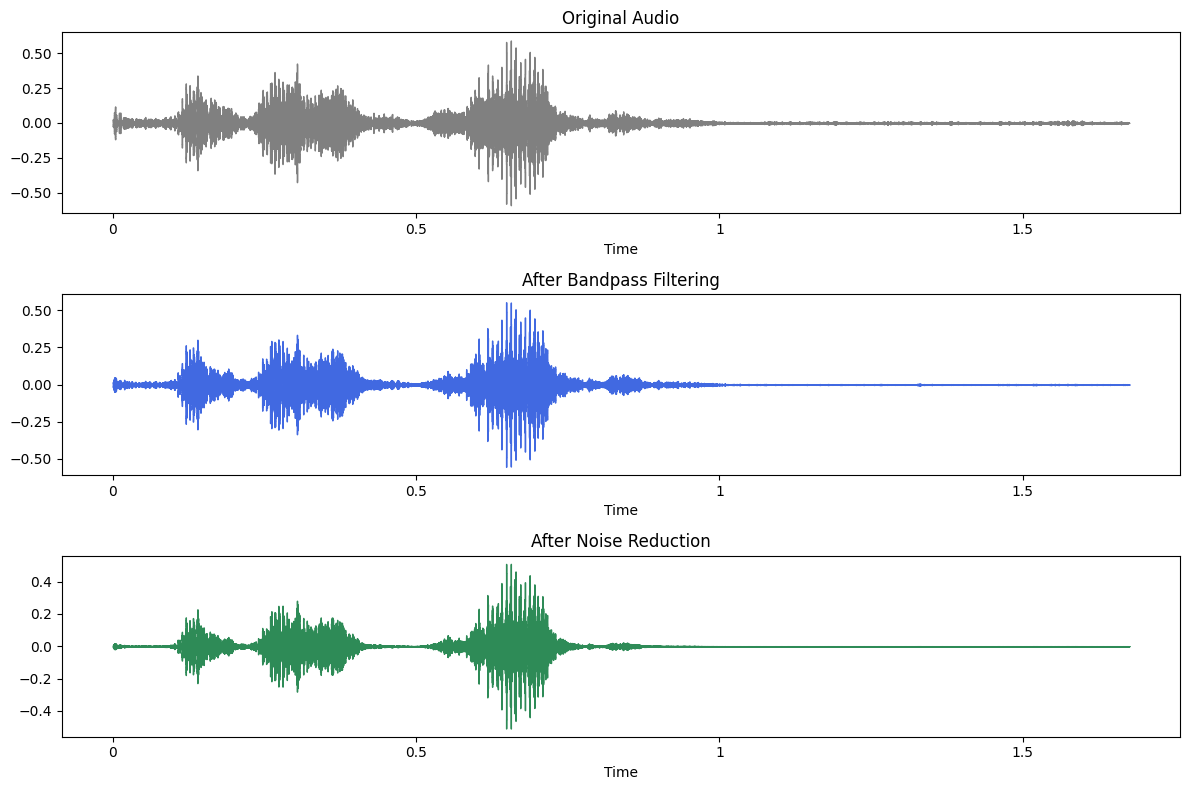


Original Audio:


After Bandpass Filtering:


After Noise Reduction:


In [5]:
from scipy.signal import butter, filtfilt
import noisereduce as nr

# Bandpass Filter Function
def butter_bandpass_filter(data, lowcut=300, highcut=3400, fs=16000, order=5):
    """
    Bandpass filter to keep only frequencies in [lowcut, highcut] Hz.
    fs: sample rate of the signal
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Demonstration on a sample audio file (neutral emotion)
path = np.array(Crema_df.Path[Crema_df.Emotions == 'angry'])[0]
data, sr = librosa.load(path, duration=2.5, offset=0.6)

# Apply filtering
filtered = butter_bandpass_filter(data, fs=sr)

# Apply noise reduction
denoised = nr.reduce_noise(y=filtered, sr=sr, y_noise=filtered[0:int(0.5 * sr)], prop_decrease=0.95)

# Plot the three versions: Original, Filtered, Denoised
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
librosa.display.waveshow(data, sr=sr, color='gray')
plt.title("Original Audio")

plt.subplot(3, 1, 2)
librosa.display.waveshow(filtered, sr=sr, color='royalblue')
plt.title("After Bandpass Filtering")

plt.subplot(3, 1, 3)
librosa.display.waveshow(denoised, sr=sr, color='seagreen')
plt.title("After Noise Reduction")

plt.tight_layout()
plt.show()

# Play the three versions
print("\nOriginal Audio:")
display(Audio(data, rate=sr))

print("After Bandpass Filtering:")
display(Audio(filtered, rate=sr))

print("After Noise Reduction:")
display(Audio(denoised, rate=sr))

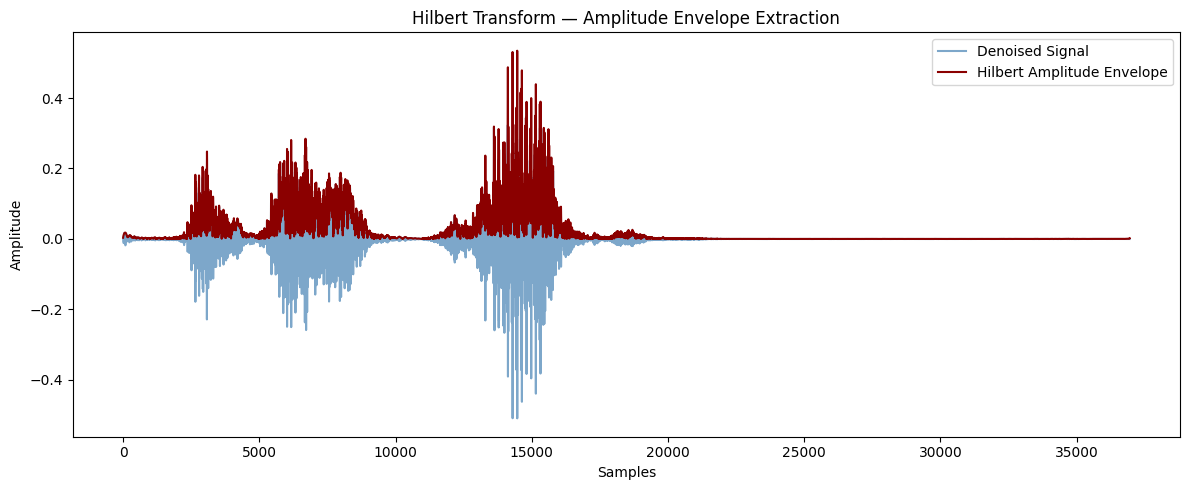

Denoised Signal:


Hilbert Amplitude Envelope:


In [6]:
from scipy.signal import hilbert

# Select a sample file (for example, "happy" emotion)
path = np.array(Crema_df.Path[Crema_df.Emotions == 'angry'])[0]
data, sr = librosa.load(path, duration=2.5, offset=0.6)

# Apply bandpass filter
filtered = butter_bandpass_filter(data, fs=sr)

# Apply noise reduction
denoised = nr.reduce_noise(y=filtered, sr=sr, y_noise=filtered[0:int(0.5 * sr)], prop_decrease=0.95)

# Apply Hilbert Transform to get the amplitude envelope
analytic_signal = hilbert(denoised)
amplitude_envelope = np.abs(analytic_signal)

# Plot the denoised signal and its Hilbert envelope
plt.figure(figsize=(12, 5))
plt.plot(denoised, label='Denoised Signal', color='steelblue', alpha=0.7)
plt.plot(amplitude_envelope, label='Hilbert Amplitude Envelope', color='darkred', linewidth=1.5)
plt.title('Hilbert Transform — Amplitude Envelope Extraction')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()

# Play audio versions
print("Denoised Signal:")
display(Audio(denoised, rate=sr))

print("Hilbert Amplitude Envelope:")
display(Audio(amplitude_envelope / np.max(amplitude_envelope), rate=sr))

In [7]:
import numpy as np
import librosa

def extract_features(data, sample_rate, n_mfcc=40, n_mels=128):
    """
    Enhanced acoustic feature extractor.
    Returns a 1-D numpy array of features including:
      - ZCR
      - Chroma STFT
      - MFCC (n_mfcc) + delta + delta-delta
      - RMS
      - Mel Spectrogram (n_mels)
      - Spectral Centroid, Bandwidth, Rolloff, Contrast
      - Pitch (f0) statistics: mean, std, median, max, min
    """
    # guard: ensure finite numeric array
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
    # small safety: if data is all zeros, return a zero vector of expected length
    # we'll compute lengths dynamically below, so handle later if needed

    features = np.array([])

    # 1) Zero Crossing Rate
    try:
        zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    except Exception:
        zcr = np.zeros(1)
    features = np.hstack((features, zcr))

    # 2) Chroma STFT
    try:
        stft = np.abs(librosa.stft(data))
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    except Exception:
        chroma = np.zeros(12)
    features = np.hstack((features, chroma))

    # 3) MFCC (n_mfcc) and deltas
    try:
        mfcc = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=n_mfcc)
        mfcc_mean = np.mean(mfcc.T, axis=0)
        mfcc_delta = np.mean(librosa.feature.delta(mfcc).T, axis=0)
        mfcc_delta2 = np.mean(librosa.feature.delta(mfcc, order=2).T, axis=0)
    except Exception:
        mfcc_mean = np.zeros(n_mfcc)
        mfcc_delta = np.zeros(n_mfcc)
        mfcc_delta2 = np.zeros(n_mfcc)
    features = np.hstack((features, mfcc_mean, mfcc_delta, mfcc_delta2))

    # 4) RMS Energy
    try:
        rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    except Exception:
        rms = np.zeros(1)
    features = np.hstack((features, rms))

    # 5) Mel Spectrogram (summarized)
    try:
        mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=n_mels).T, axis=0)
    except Exception:
        mel = np.zeros(n_mels)
    features = np.hstack((features, mel))

    # 6) Spectral features: centroid, bandwidth, rolloff, contrast
    try:
        spec_centroid = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)
        spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T, axis=0)
        spec_rolloff = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate).T, axis=0)
        spec_contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
    except Exception:
        # sizes: centroid, bw, rolloff -> 1 each; contrast -> usually 7
        spec_centroid = np.zeros(1)
        spec_bw = np.zeros(1)
        spec_rolloff = np.zeros(1)
        spec_contrast = np.zeros(7)
    features = np.hstack((features, spec_centroid, spec_bw, spec_rolloff, spec_contrast))

    # 7) Pitch (F0) statistics via piptrack
    try:
        pitches, magnitudes = librosa.piptrack(y=data, sr=sample_rate)
        # collect non-zero pitch entries
        pitch_values = pitches[magnitudes > np.median(magnitudes)]
        # fallback to non-zero positives if above condition yields empty
        if pitch_values.size == 0:
            pitch_values = pitches[pitches > 0]
        # compute stats safely
        if pitch_values.size == 0:
            pitch_stats = np.array([0., 0., 0., 0., 0.])  # mean, std, median, max, min
        else:
            pitch_stats = np.array([
                np.mean(pitch_values),
                np.std(pitch_values),
                np.median(pitch_values),
                np.max(pitch_values),
                np.min(pitch_values)
            ])
    except Exception:
        pitch_stats = np.zeros(5)
    features = np.hstack((features, pitch_stats))

    # final safety: replace any NaN/inf and flatten to 1-D
    features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    features = np.real(features).astype(np.float32)

    return features


def get_features(path):
    """
    Full get_features pipeline:
      - load file
      - bandpass filter
      - noise reduction
      - hilbert envelope combination
      - feature extraction using extract_features()
    """
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # Bandpass filter
    data = butter_bandpass_filter(data, lowcut=300, highcut=3400, fs=sample_rate, order=5)

    # Noise reduction
    noise_part = data[0:int(0.5 * sample_rate)]
    data = nr.reduce_noise(y=data, sr=sample_rate, y_noise=noise_part, prop_decrease=0.95)

    # Hilbert transform -> amplitude envelope
    analytic_signal = hilbert(data)
    amplitude_envelope = np.abs(analytic_signal)

    # Combine original + envelope (as you used before)
    combined_signal = 0.5 * (data + amplitude_envelope)

    # Clean non-finite and real-only
    combined_signal = np.nan_to_num(combined_signal, nan=0.0, posinf=0.0, neginf=0.0)
    combined_signal = np.real(combined_signal)

    # Extract features (use higher MFCC and mel resolution)
    result = extract_features(combined_signal, sample_rate, n_mfcc=40, n_mels=128)
    return result

In [8]:
from tqdm import tqdm
import pandas as pd
import numpy as np

features_list = []
labels_list = []
bad_files = []

# Loop over CREMA files and extract features
for path, emotion in tqdm(zip(Crema_df.Path, Crema_df.Emotions), total=len(Crema_df)):
    try:
        feat = get_features(path)   # uses enhanced pipeline
        features_list.append(feat)
        labels_list.append(emotion)
    except Exception as e:
        bad_files.append((path, str(e)))
        # continue processing remaining files
        continue

# Convert to DataFrame (features might have varying lengths if something went wrong,
# so ensure uniformity by padding/truncating to the max length)
max_len = max([len(f) for f in features_list])
clean_features = [np.pad(f, (0, max_len - len(f)), mode='constant') for f in features_list]

Features = pd.DataFrame(clean_features)
Features['labels'] = labels_list

# Save to CSV
out_csv = "crema_features_enhanced.csv"
Features.to_csv(out_csv, index=False)

# Summary
print(f"Saved features to {out_csv}")
print(f"Extracted features for {len(Features)} files. Skipped {len(bad_files)} files.")
if len(bad_files) > 0:
    print("\nExamples of skipped files and errors:")
    for p, err in bad_files[:5]:
        print(p, "->", err)

# Show a quick preview and shape
display(Features.head())
print("Feature vector length (per sample):", Features.shape[1] - 1)

 83%|████████▎ | 6187/7442 [09:08<01:55, 10.91it/s]c:\Users\Srinjoy\AppData\Local\Programs\Python\Python312\Lib\site-packages\noisereduce\spectralgate\nonstationary.py:70: RuntimeWarning: invalid value encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth
100%|██████████| 7442/7442 [11:06<00:00, 11.16it/s]


Saved features to crema_features_enhanced.csv
Extracted features for 7442 files. Skipped 0 files.


,0,1,2,3,4,5,6,7,8,9,...,268,269,270,271,272,273,274,275,276,labels
0,0.0,0.685074,0.668031,0.674816,0.732270,0.747586,0.677664,0.657964,0.688645,0.664734,...,14.169254,18.105244,19.811419,14.311031,786.423340,721.698242,474.522430,3001.926025,147.428467,angry
1,0.0,0.707105,0.688668,0.707362,0.783306,0.761636,0.681312,0.651594,0.696602,0.704757,...,13.763879,18.307074,20.340460,14.975512,887.011230,801.086609,482.377380,3598.375488,149.187836,disgust
2,0.0,0.597979,0.642627,0.685096,0.723641,0.716570,0.671011,0.627461,0.718430,0.695953,...,14.243183,17.882843,19.852161,14.884926,829.550110,719.218750,462.032135,2983.744629,147.367615,fear
3,0.0,0.692962,0.693243,0.712606,0.720163,0.732600,0.727685,0.678070,0.656069,0.705442,...,14.392822,18.445368,19.300941,14.750006,589.934021,558.582458,400.013885,3001.277832,148.304459,happy
4,0.0,0.701582,0.687660,0.695696,0.748222,0.771903,0.693561,0.686791,0.714722,0.707135,...,13.858200,18.166716,20.733292,14.819650,795.247803,740.358948,454.160309,3151.294678,146.480225,neutral


Feature vector length (per sample): 277


In [9]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import joblib

# Load enhanced features (if not already in memory)
features_csv = "crema_features_enhanced.csv"
Features = pd.read_csv(features_csv)

# Quick check
print("Loaded features:", Features.shape)
display(Features.head())

# Separate features and labels
X = Features.drop(columns=['labels'])
y = Features['labels']

# Encode labels to integers
le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = le.classes_
print("Classes:", list(class_names))

# Show class distribution
dist = Counter(y_enc)
print("\nClass distribution (label index : count):")
for idx, cnt in sorted(dist.items()):
    print(f"{idx} ({class_names[idx]}): {cnt}")

# Stratified Train/Test split (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

print("\nShapes after split:")
print("x_train:", x_train.shape)
print("x_test: ", x_test.shape)
print("y_train:", y_train.shape)
print("y_test: ", y_test.shape)

# Scale features (fit on train, apply to test)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print("\nScaling applied. Example feature means (first 5):", np.round(x_train.mean(axis=0)[:5], 6))
print("Example feature stds (first 5):", np.round(x_train.std(axis=0)[:5], 6))

Loaded features: (7442, 278)


,0,1,2,3,4,5,6,7,8,9,...,268,269,270,271,272,273,274,275,276,labels
0,0.0,0.685074,0.668031,0.674816,0.732270,0.747586,0.677664,0.657964,0.688645,0.664734,...,14.169254,18.105244,19.811419,14.311031,786.42334,721.69824,474.52243,3001.9260,147.42847,angry
1,0.0,0.707105,0.688668,0.707362,0.783306,0.761636,0.681312,0.651594,0.696602,0.704757,...,13.763879,18.307074,20.340460,14.975512,887.01120,801.08660,482.37738,3598.3755,149.18784,disgust
2,0.0,0.597979,0.642627,0.685096,0.723641,0.716570,0.671011,0.627461,0.718430,0.695953,...,14.243183,17.882843,19.852161,14.884926,829.55010,719.21875,462.03214,2983.7446,147.36761,fear
3,0.0,0.692962,0.693243,0.712606,0.720163,0.732600,0.727685,0.678070,0.656069,0.705442,...,14.392822,18.445368,19.300941,14.750006,589.93400,558.58246,400.01390,3001.2778,148.30446,happy
4,0.0,0.701582,0.687660,0.695696,0.748222,0.771903,0.693561,0.686791,0.714722,0.707135,...,13.858200,18.166716,20.733292,14.819650,795.24780,740.35895,454.16030,3151.2947,146.48022,neutral


Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']

Class distribution (label index : count):
0 (angry): 1271
1 (disgust): 1271
2 (fear): 1271
3 (happy): 1271
4 (neutral): 1087
5 (sad): 1271

Shapes after split:
x_train: (5953, 277)
x_test:  (1489, 277)
y_train: (5953,)
y_test:  (1489,)

Scaling applied. Example feature means (first 5): [ 0. -0. -0.  0.  0.]
Example feature stds (first 5): [0. 1. 1. 1. 1.]


Training SVM on enhanced features...
SVM Accuracy: 0.4856

Classification Report:
              precision    recall  f1-score   support

       angry       0.58      0.69      0.63       254
     disgust       0.40      0.39      0.40       254
        fear       0.42      0.33      0.37       254
       happy       0.45      0.42      0.43       255
     neutral       0.53      0.53      0.53       218
         sad       0.51      0.56      0.53       254

    accuracy                           0.49      1489
   macro avg       0.48      0.49      0.48      1489
weighted avg       0.48      0.49      0.48      1489



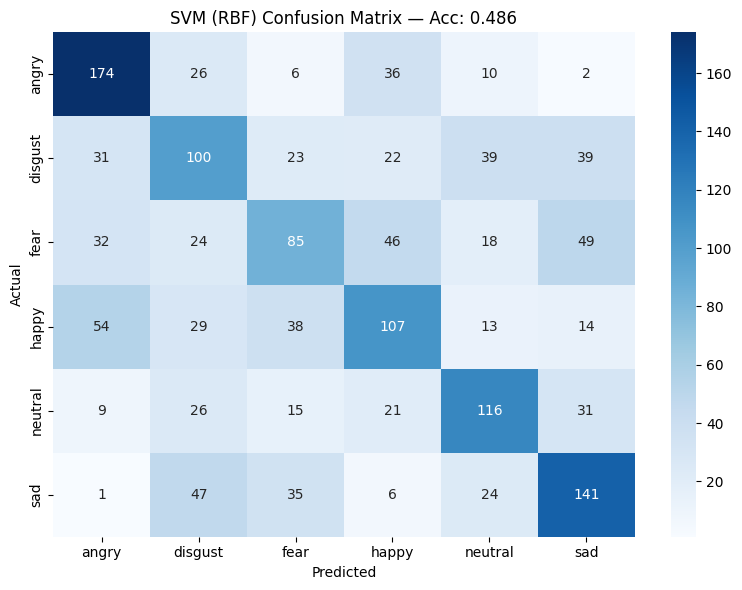

In [10]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Instantiate SVM (RBF). You can set class_weight='balanced' if needed.
svm_model = SVC(kernel='rbf', C=10, gamma='scale', probability=False, random_state=42)

print("Training SVM on enhanced features...")
svm_model.fit(x_train, y_train)

# Predict
y_pred = svm_model.predict(x_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {acc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f"SVM (RBF) Confusion Matrix — Acc: {acc:.3f}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

Training Random Forest...

Random Forest Accuracy: 0.4849

Classification Report:
              precision    recall  f1-score   support

       angry       0.61      0.69      0.64       254
     disgust       0.42      0.30      0.35       254
        fear       0.64      0.17      0.26       254
       happy       0.39      0.46      0.42       255
     neutral       0.43      0.59      0.50       218
         sad       0.51      0.72      0.60       254

    accuracy                           0.48      1489
   macro avg       0.50      0.49      0.46      1489
weighted avg       0.50      0.48      0.46      1489



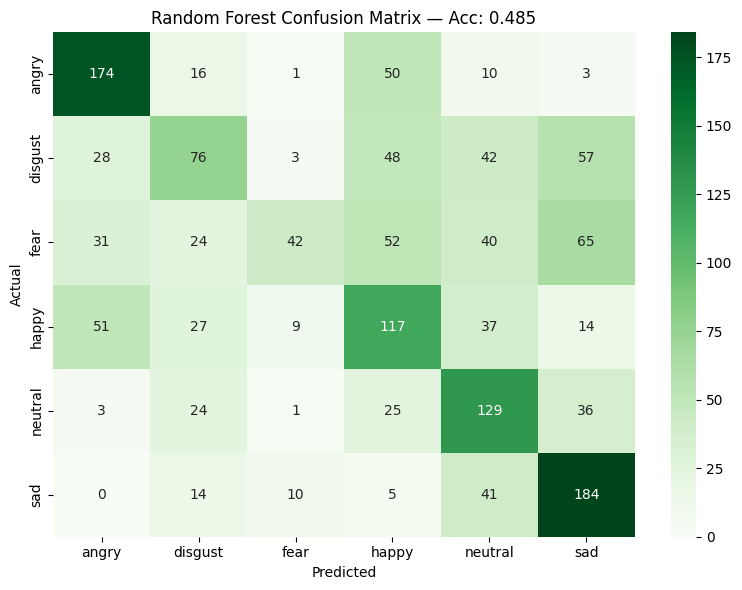

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Training Random Forest...")

# Initialize and train the model
rf_model = RandomForestClassifier(
    n_estimators=1000,       # number of trees
    max_depth=None,         # let trees expand fully
    min_samples_split=2,    # default split rule
    random_state=42,
    n_jobs=-1               # use all CPU cores
)

rf_model.fit(x_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(x_test)

# Evaluation
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nRandom Forest Accuracy: {acc_rf:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8,6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f"Random Forest Confusion Matrix — Acc: {acc_rf:.3f}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Training KNN...

KNN Accuracy: 0.3371

Classification Report:
              precision    recall  f1-score   support

       angry       0.65      0.52      0.58       254
     disgust       0.24      0.38      0.29       254
        fear       0.26      0.29      0.28       254
       happy       0.38      0.18      0.24       255
     neutral       0.29      0.19      0.23       218
         sad       0.34      0.44      0.39       254

    accuracy                           0.34      1489
   macro avg       0.36      0.33      0.33      1489
weighted avg       0.36      0.34      0.34      1489



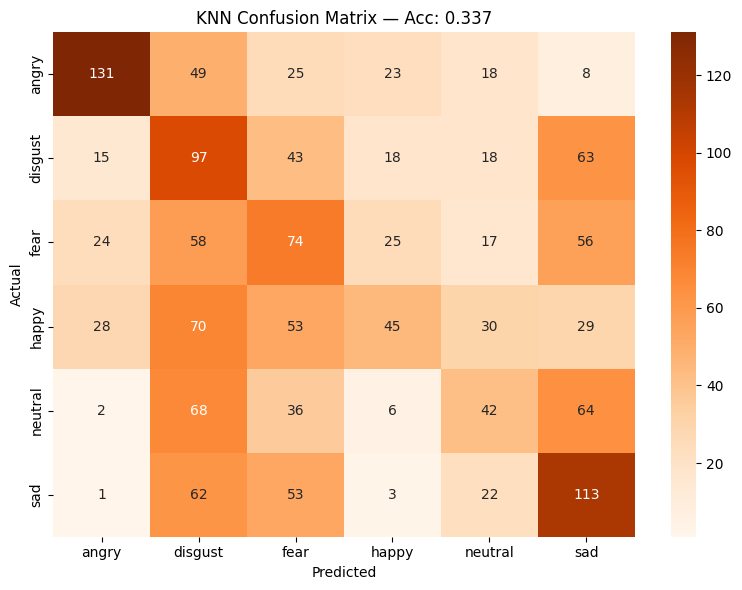

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

print("Training KNN...")

# Initialize KNN (you can change n_neighbors)
knn_model = KNeighborsClassifier(n_neighbors=7, weights='distance', n_jobs=-1)

# Train
knn_model.fit(x_train, y_train)

# Predict
y_pred_knn = knn_model.predict(x_test)

# Evaluate
acc_knn = accuracy_score(y_test, y_pred_knn)
print(f"\nKNN Accuracy: {acc_knn:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_knn, target_names=le.classes_))

# Confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8,6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Oranges',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f"KNN Confusion Matrix — Acc: {acc_knn:.3f}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Training Decision Tree...
Decision Tree Accuracy: 0.3163

Classification Report:
              precision    recall  f1-score   support

       angry       0.50      0.47      0.49       254
     disgust       0.24      0.26      0.25       254
        fear       0.23      0.25      0.24       254
       happy       0.27      0.25      0.26       255
     neutral       0.26      0.22      0.24       218
         sad       0.39      0.43      0.41       254

    accuracy                           0.32      1489
   macro avg       0.32      0.31      0.31      1489
weighted avg       0.32      0.32      0.32      1489



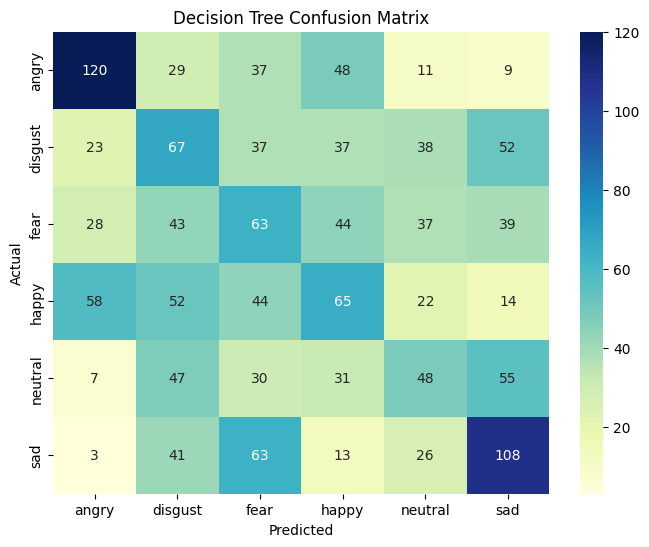

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define emotion class labels (for CREMA-D)
class_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']

# Initialize and train the model
print("Training Decision Tree...")
dt_model = DecisionTreeClassifier(
    criterion='gini',       # can use 'entropy' or 'log_loss' too
    max_depth=None,         # None = grow full tree (can try 10 for pruning)
    min_samples_split=2,    # minimum samples to split an internal node
    random_state=42
)

# Fit model
dt_model.fit(x_train, y_train)

# Predictions
y_pred_dt = dt_model.predict(x_test)

# Evaluation metrics
dt_acc = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {dt_acc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred_dt, target_names=class_labels))

# Confusion Matrix visualization
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8,6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Training ElasticNet Logistic Regression...
ElasticNet Logistic Regression Accuracy: 0.4835

Classification Report:
              precision    recall  f1-score   support

       angry       0.65      0.59      0.62       254
     disgust       0.43      0.41      0.42       254
        fear       0.41      0.34      0.37       254
       happy       0.46      0.46      0.46       255
     neutral       0.45      0.48      0.47       218
         sad       0.49      0.61      0.55       254

    accuracy                           0.48      1489
   macro avg       0.48      0.48      0.48      1489
weighted avg       0.48      0.48      0.48      1489



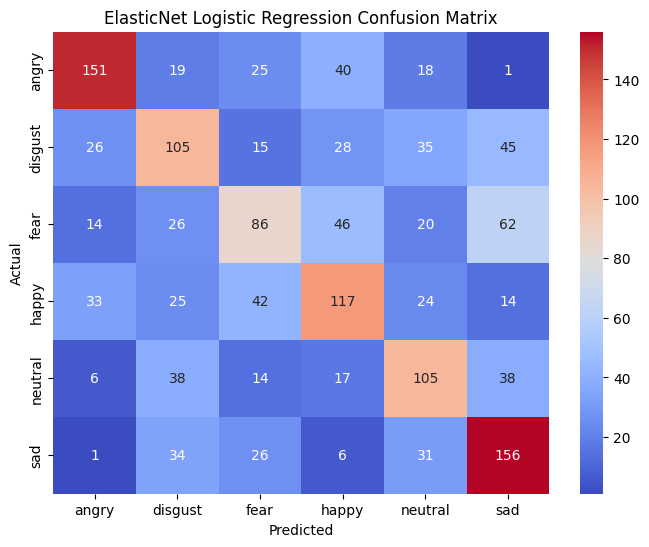

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define class labels for CREMA-D
class_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']

print("Training ElasticNet Logistic Regression...")

# Initialize the model
elastic_model = LogisticRegression(
    penalty='elasticnet',   # Combination of L1 + L2
    solver='saga',          # Required for elasticnet
    l1_ratio=0.5,           # 0 = pure Ridge, 1 = pure Lasso; 0.5 = balanced
    max_iter=5000,          # Allow convergence
    random_state=42,
    n_jobs=-1
)

# Train model
elastic_model.fit(x_train, y_train)

# Predictions
y_pred_elastic = elastic_model.predict(x_test)

# Evaluation
elastic_acc = accuracy_score(y_test, y_pred_elastic)
print(f"ElasticNet Logistic Regression Accuracy: {elastic_acc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred_elastic, target_names=class_labels))

# Confusion Matrix
cm_elastic = confusion_matrix(y_test, y_pred_elastic)
plt.figure(figsize=(8,6))
sns.heatmap(cm_elastic, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("ElasticNet Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()